In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
GFF_FILE = "Arabidopsis_lyrata.v.1.0.62.gff3"
CLUST_FILE = "medium_gene_cluster_membership.tsv"

In [3]:
clusters = pd.read_csv(
    CLUST_FILE,
    sep=r"\s+",
    header=None,
    names=["gene_id", "dup_group"]
)

# Let's make a "gene duplicated" flag
clusters["is_dup"] = True

In [4]:
# Read GFF3 and extract the gene coordinates
gff_cols = [
    "seqid", "source", "type",
    "start", "end", "score",
    "strand", "phase", "attributes"
]

gff = pd.read_csv(
    GFF_FILE,
    sep="\t",
    comment="#",
    names=gff_cols,
    dtype={"seqid": str}
)


In [5]:
# take only rows with the type "gene"
genes = gff[gff["type"] == "gene"].copy()

def extract_id(attr: str):
    for part in str(attr).split(";"):
        part = part.strip()
        if part.startswith("ID="):
            gene_id = part[3:]
            if gene_id.startswith("gene:"):
                gene_id = gene_id[len("gene:"):]
            return gene_id
    return None

genes["gene_id"] = genes["attributes"].map(extract_id)

gene_coords = genes[["gene_id", "seqid", "start", "end"]].rename(
    columns={"seqid": "chr"}
)

# we attach information about duplication
all_genes = gene_coords.merge(
    clusters[["gene_id", "dup_group", "is_dup"]],
    on="gene_id",
    how="left"
)


In [6]:
# genes that are not in the cluster file are considered NOT duplicated
all_genes["is_dup"] = all_genes["is_dup"].fillna(False)

# save
all_genes.to_csv("genes_with_clusters.tsv", sep="\t", index=False)

# we count by chromosomes
summary = (
    all_genes
    .groupby("chr")
    .agg(
        total_genes=("gene_id", "count"),
        dup_genes=("is_dup", "sum")
    )
)

summary["dup_fraction"] = summary["dup_genes"] / summary["total_genes"]

summary.to_csv("dup_fraction_per_chr.tsv", sep="\t")

print("Proportion of duplicated genes on chromosomes:")
print(summary)

Proportion of duplicated genes on chromosomes:
              total_genes  dup_genes  dup_fraction
chr                                               
1                    5380       3894      0.723792
2                    3006       2170      0.721890
3                    4216       3001      0.711812
4                    3640       2622      0.720330
5                    3470       2504      0.721614
...                   ...        ...           ...
scaffold_989            2          0      0.000000
scaffold_990            1          0      0.000000
scaffold_991            1          0      0.000000
scaffold_994            2          0      0.000000
scaffold_998            2          0      0.000000

[437 rows x 3 columns]


C:\Users\DELL\AppData\Local\Temp\ipykernel_21728\3589361585.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_genes["is_dup"] = all_genes["is_dup"].fillna(False)


In [7]:
df = pd.read_csv("dup_fraction_per_chr.tsv", sep="\t")
df.head(15)

,chr,total_genes,dup_genes,dup_fraction
0,1,5380,3894,0.723792
1,2,3006,2170,0.721890
2,3,4216,3001,0.711812
3,4,3640,2622,0.720330
4,5,3470,2504,0.721614
5,6,4177,2961,0.708882
6,7,4113,2996,0.728422
7,8,3476,2430,0.699079
8,scaffold_100,2,0,0.000000
9,scaffold_1006,1,0,0.000000


In [8]:
df_clean = df[~df["chr"].astype(str).str.startswith("scaffold")]
df_clean.head(15)

,chr,total_genes,dup_genes,dup_fraction
0,1,5380,3894,0.723792
1,2,3006,2170,0.721890
2,3,4216,3001,0.711812
3,4,3640,2622,0.720330
4,5,3470,2504,0.721614
5,6,4177,2961,0.708882
6,7,4113,2996,0.728422
7,8,3476,2430,0.699079


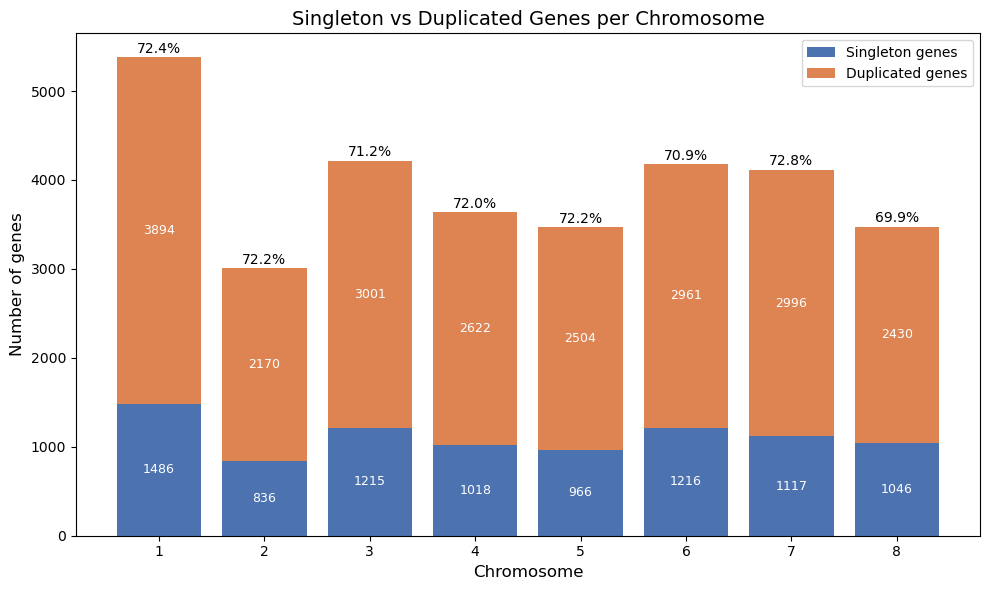

In [9]:
import matplotlib.pyplot as plt
import numpy as np

df_plot = df_clean.copy()
df_plot["chr"] = df_plot["chr"].astype(int)
df_plot = df_plot.sort_values("chr")

# data
chroms = df_plot["chr"].astype(str).tolist()
dup = df_plot["dup_genes"].values
total = df_plot["total_genes"].values
singletons = total - dup

dup_pct = dup / total * 100

fig, ax = plt.subplots(figsize=(10,6))

x = np.arange(len(chroms))

# --- Bars ---
# Singleton (BLUE)
ax.bar(x, singletons, label="Singleton genes", color="#4C72B0")

# Duplicated (ORANGE)
ax.bar(x, dup, bottom=singletons, label="Duplicated genes", color="#DD8452")

# --- Text labels inside each bar ---
for xi, s, d, t in zip(x, singletons, dup, total):
    # label inside singleton part
    ax.text(xi, s/2, f"{s}", ha="center", va="center", color="white", fontsize=9)
    
    # label inside duplicated part
    ax.text(xi, s + d/2, f"{d}", ha="center", va="center", color="white", fontsize=9)
    
    # percentage on top of bar
    ax.text(xi, t + 50, f"{(d/t)*100:.1f}%", ha="center", fontsize=10)

# --- Axes & Title ---
ax.set_xticks(x)
ax.set_xticklabels(chroms)
ax.set_xlabel("Chromosome", fontsize=12)
ax.set_ylabel("Number of genes", fontsize=12)
ax.set_title("Singleton vs Duplicated Genes per Chromosome", fontsize=14)

ax.legend()
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# ------------------------------------------------------------------
# Table contenant le nombre total de gènes et de gènes dupliqués
# par chromosome (issue de l'analyse précédente)
# ------------------------------------------------------------------

df = pd.DataFrame({
    "chr": [1, 2, 3, 4, 5, 6, 7, 8],
    "total_genes": [5380, 3006, 4216, 3640, 3470, 4177, 4113, 3476],
    "dup_genes": [3894, 2170, 3001, 2622, 2504, 2961, 2996, 2430]
})

# Calcul du nombre de singletons
df["singleton_genes"] = df["total_genes"] - df["dup_genes"]

# ------------------------------------------------------------------
# Construction de la table de contingence :
# lignes = chromosomes
# colonnes = statut de duplication (singleton / dupliqué)
# ------------------------------------------------------------------

contingency_table = df[["singleton_genes", "dup_genes"]]
contingency_table.index = df["chr"]

# ------------------------------------------------------------------
# Test du chi-deux d'indépendance
# H0 : le statut de duplication est indépendant du chromosome
# ------------------------------------------------------------------

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Résultat du test du chi-deux :")
print(f"Chi² = {chi2:.3f}")
print(f"Degrés de liberté = {dof}")
print(f"p-value = {p_value:.4e}")

# ------------------------------------------------------------------
# Calcul de la taille d'effet : V de Cramér
# Permet d'évaluer l'importance biologique de l'effet
# ------------------------------------------------------------------

n = contingency_table.to_numpy().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print(f"V de Cramér = {cramers_v:.4f}")


Résultat du test du chi-deux :
Chi² = 12.198
Degrés de liberté = 7
p-value = 9.4229e-02
V de Cramér = 0.0197


In [11]:
# Nombre total de gènes dans le génome
N_total = df_clean["total_genes"].sum()

# Nombre total de gènes dupliqués
N_dup = df_clean["dup_genes"].sum()

# Vecteur binaire : 1 = dupliqué, 0 = singleton
dup_labels = np.array([1]*N_dup + [0]*(N_total - N_dup))

# Tailles des chromosomes (nombre de gènes par chromosome)
chr_sizes = df_clean["total_genes"].values


In [12]:
# Fraction observée de duplications par chromosome
observed_fractions = df_clean["dup_fraction"].values

# Statistique observée : variance
observed_stat = np.var(observed_fractions)


In [13]:
n_perm = 10000
perm_stats = []

for i in range(n_perm):
    # Mélange aléatoire des labels duplication
    np.random.shuffle(dup_labels)

    idx = 0
    perm_fractions = []

    # Recalcul des fractions par chromosome
    for size in chr_sizes:
        chrom_labels = dup_labels[idx:idx+size]
        perm_fractions.append(chrom_labels.mean())
        idx += size

    perm_stats.append(np.var(perm_fractions))

perm_stats = np.array(perm_stats)


In [14]:
p_value_perm = np.mean(perm_stats >= observed_stat)

print("Test de permutation :")
print(f"Variance observée = {observed_stat:.6f}")
print(f"p-value = {p_value_perm:.4f}")


Test de permutation :
Variance observée = 0.000081
p-value = 0.0944


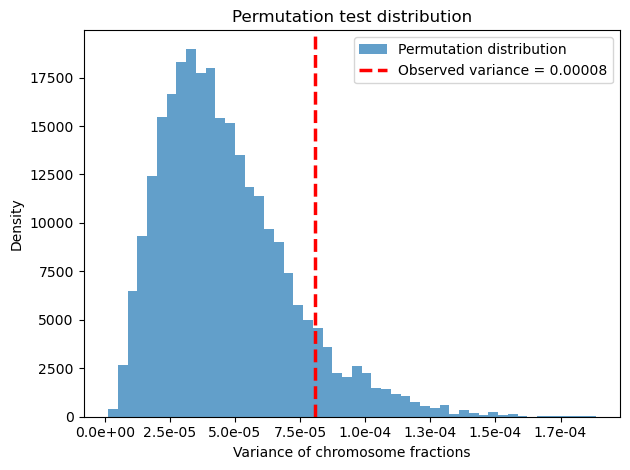

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.figure()

# Гистограмма
plt.hist(
    perm_stats,
    bins=50,
    density=True,
    alpha=0.7,
    label="Permutation distribution"
)

# Красная линия
plt.axvline(
    observed_stat,
    color="red",
    linestyle="--",
    linewidth=2.5,
    label=f"Observed variance = {observed_stat:.5f}"
)

# Формат оси X (научная нотация или аккуратные десятичные)
plt.gca().xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{x:.1e}")
)

plt.xlabel("Variance of chromosome fractions")
plt.ylabel("Density")
plt.title("Permutation test distribution")
plt.legend()

plt.tight_layout()
plt.show()


